## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [3]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [4]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

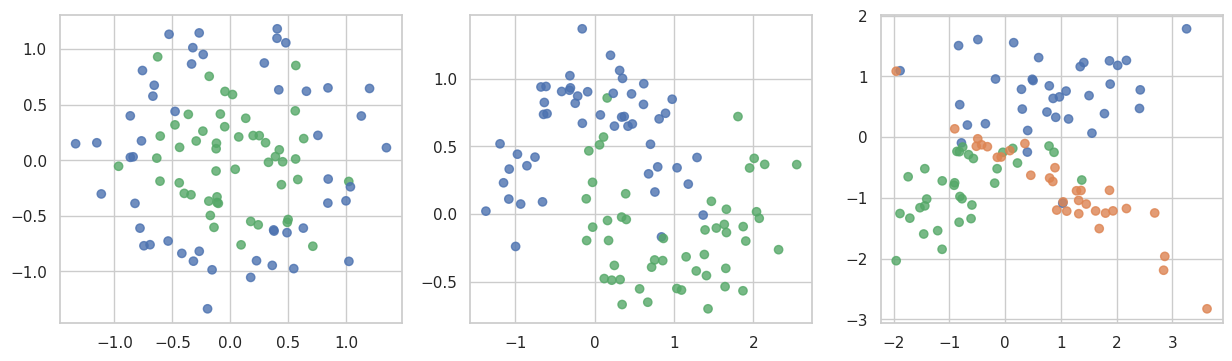

In [5]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

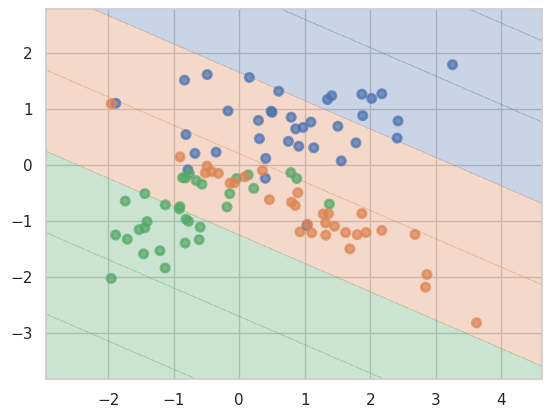

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

__Ответ:__

     Данные  Train  Test  Разница  Глубина
0     Круги  1.000 0.700    0.300        6
1    Месяцы  1.000 0.933    0.067        6
2  3 класса  1.000 0.933    0.067        3


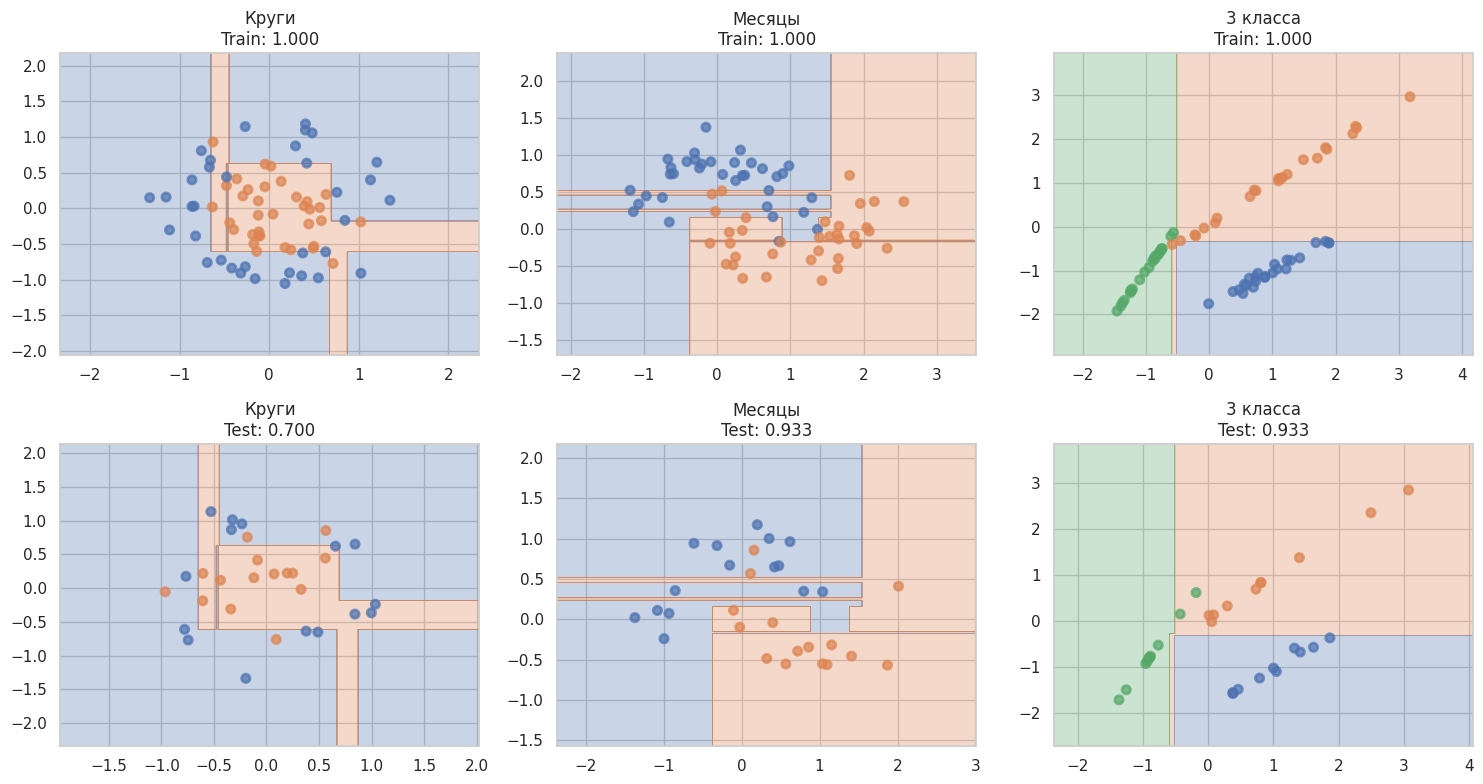

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons, make_circles, make_classification

# Параметры
SEED = 42
TEST_SIZE = 0.3
names = ["Круги", "Месяцы", "3 класса"]
results = []

# Создание данных
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=SEED),
    make_moons(noise=0.2, random_state=SEED),
    make_classification(n_classes=3, n_features=2, n_redundant=0,
                       n_clusters_per_class=1, random_state=SEED),
]

plt.figure(figsize=(15, 8))

for idx, ((X, y), name) in enumerate(zip(datasets, names)):
    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
    )

    # Обучение модели
    model = DecisionTreeClassifier(random_state=SEED)
    model.fit(X_train, y_train)

    # Оценка качества
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    # Сохранение результатов
    results.append({
        "Данные": name,
        "Train": train_acc,
        "Test": test_acc,
        "Разница": train_acc - test_acc,
        "Глубина": model.get_depth()
    })

    # Визуализация
    plt.subplot(2, 3, idx + 1)
    plot_surface(model, X_train, y_train)
    plt.title(f"{name}\nTrain: {train_acc:.3f}")

    plt.subplot(2, 3, idx + 4)
    plot_surface(model, X_test, y_test)
    plt.title(f"{name}\nTest: {test_acc:.3f}")

plt.tight_layout()

# Вывод результатов
df_results = pd.DataFrame(results)
print(df_results.to_string(float_format=lambda x: f'{x:.3f}'))

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

__Ответ:__

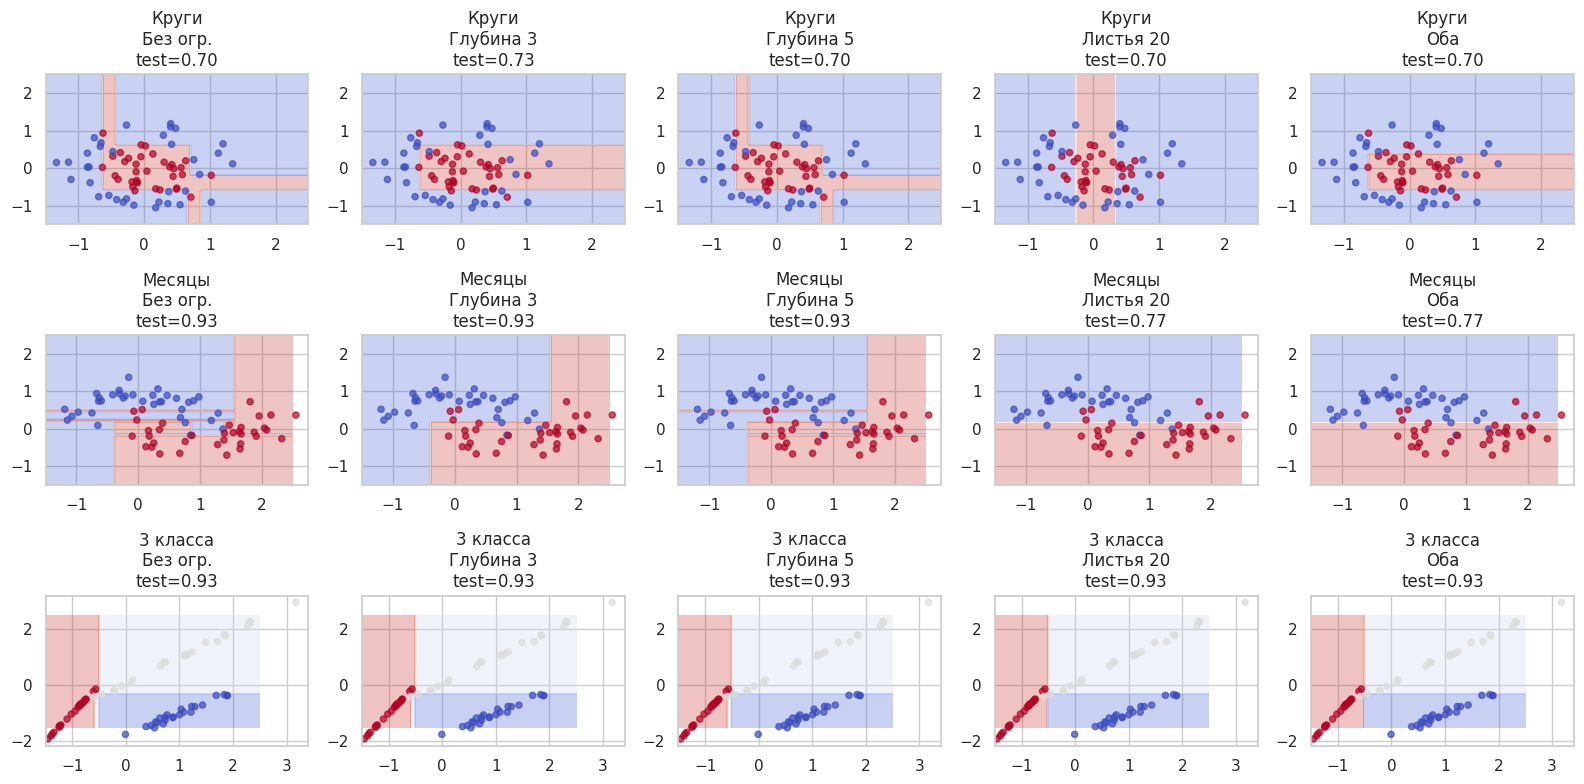

Результаты:
Данные     3 класса  Круги  Месяцы
Параметры                         
Без огр.      0.933  0.700   0.933
Глубина 3     0.933  0.733   0.933
Глубина 5     0.933  0.700   0.933
Листья 20     0.933  0.700   0.767
Оба           0.933  0.700   0.767


In [9]:
# Параметры регуляризации
params = [
    {"name": "Без огр.", "max_depth": None, "min_samples_leaf": 1},
    {"name": "Глубина 3", "max_depth": 3, "min_samples_leaf": 1},
    {"name": "Глубина 5", "max_depth": 5, "min_samples_leaf": 1},
    {"name": "Листья 20", "max_depth": None, "min_samples_leaf": 20},
    {"name": "Оба", "max_depth": 4, "min_samples_leaf": 10},
]

# Фиксированное разбиение
SEED = 42
train_test_splits = []
for X, y in datasets:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=SEED, stratify=y
    )
    train_test_splits.append((X_train, X_test, y_train, y_test))

# Визуализация
fig, axes = plt.subplots(3, 5, figsize=(16, 8))
results = []

for i, ((X_train, X_test, y_train, y_test), name) in enumerate(zip(train_test_splits, names)):
    for j, p in enumerate(params):
        model = DecisionTreeClassifier(
            max_depth=p["max_depth"],
            min_samples_leaf=p["min_samples_leaf"],
            random_state=SEED
        )
        model.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, model.predict(X_train))
        test_acc = accuracy_score(y_test, model.predict(X_test))

        results.append({
            "Данные": name,
            "Параметры": p["name"],
            "Train": train_acc,
            "Test": test_acc,
            "Разница": train_acc - test_acc
        })

        # Визуализация
        xx, yy = np.meshgrid(np.linspace(-1.5, 2.5, 100),
                            np.linspace(-1.5, 2.5, 100))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        axes[i, j].contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        axes[i, j].scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm', s=20, alpha=0.7)
        axes[i, j].set_title(f"{name}\n{p['name']}\ntest={test_acc:.2f}")

plt.tight_layout()
plt.show()

# Результаты
df = pd.DataFrame(results)
print("Результаты:")
print(df.pivot_table(index="Параметры", columns="Данные", values="Test").round(3))

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
cols = ['class','cap-shape','cap-surface','cap-color','bruises','odor',
        'gill-attachment','gill-spacing','gill-size','gill-color',
        'stalk-shape','stalk-root','stalk-surface-above-ring',
        'stalk-surface-below-ring','stalk-color-above-ring',
        'stalk-color-below-ring','veil-type','veil-color','ring-number',
        'ring-type','spore-print-color','population','habitat']

df = pd.read_csv(url, header=None, names=cols)

# Кодируем все категориальные признаки
le = LabelEncoder()
df_encoded = df.apply(lambda x: le.fit_transform(x))

# Разделяем на признаки и целевую переменную
X = df_encoded.drop('class', axis=1)
y = df_encoded['class']

# 50/50 разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# Обучаем дерево
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Предсказания и accuracy
y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy на тестовой выборке: {acc:.4f}")
print(f"Глубина дерева: {tree.get_depth()}")
print(f"Количество листьев: {tree.get_n_leaves()}")
print(f"\nРазмеры данных:")
print(f"  Всего записей: {len(df)}")
print(f"  Обучающая выборка: {len(X_train)}")
print(f"  Тестовая выборка: {len(X_test)}")

# Дополнительно: точность на обучающей
train_acc = accuracy_score(y_train, tree.predict(X_train))
print(f"Accuracy на обучающей: {train_acc:.4f}")

Accuracy на тестовой выборке: 1.0000
Глубина дерева: 7
Количество листьев: 20

Размеры данных:
  Всего записей: 8124
  Обучающая выборка: 4062
  Тестовая выборка: 4062
Accuracy на обучающей: 1.0000


__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder.

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

# Настройки
CV = 10
RANDOM_STATE = 42
scorer = make_scorer(accuracy_score)

# Функция для загрузки данных из интернета
def load_dataset(name):
    urls = {
        'mushrooms': 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
        'tic-tac-toe': 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
        'cars': 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
        'nursery': 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data'
    }

    if name in urls:
        return pd.read_csv(urls[name], header=None)
    else:
        # Для user-knowledge используем локальный путь или другой источник
        # Временно создадим тестовые данные
        return pd.DataFrame(np.random.randint(0, 10, (403, 6)))

# Словарь для хранения результатов
results = {}

# 1. Mushrooms dataset
print("Обработка Mushrooms dataset...")
mushrooms = load_dataset('mushrooms')
mushrooms_cols = ['class','cap-shape','cap-surface','cap-color','bruises','odor',
                 'gill-attachment','gill-spacing','gill-size','gill-color',
                 'stalk-shape','stalk-root','stalk-surface-above-ring',
                 'stalk-surface-below-ring','stalk-color-above-ring',
                 'stalk-color-below-ring','veil-type','veil-color','ring-number',
                 'ring-type','spore-print-color','population','habitat']
mushrooms.columns = mushrooms_cols

# Кодируем все категориальные признаки
le = LabelEncoder()
mushrooms_encoded = mushrooms.apply(lambda x: le.fit_transform(x))
X_mush = mushrooms_encoded.drop('class', axis=1)
y_mush = mushrooms_encoded['class']

# 2. Tic-Tac-Toe dataset
print("Обработка Tic-Tac-Toe dataset...")
tic = load_dataset('tic-tac-toe')
tic_encoded = tic.apply(lambda x: le.fit_transform(x))
X_tic = tic_encoded.iloc[:, :-1]
y_tic = tic_encoded.iloc[:, -1]

# 3. Cars dataset
print("Обработка Cars dataset...")
cars = load_dataset('cars')
cars.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

# Правильное бинарное кодирование целевой переменной
class_mapping = {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}
y_cars = cars['class'].map(class_mapping)

# Кодируем остальные признаки
cars_features = cars.drop('class', axis=1)
cars_encoded = cars_features.apply(lambda x: le.fit_transform(x))
X_cars = cars_encoded

# 4. Nursery dataset
print("Обработка Nursery dataset...")
nursery = load_dataset('nursery')

# Кодируем все признаки
nursery_encoded = nursery.apply(lambda x: le.fit_transform(x))

# Правильное бинарное кодирование целевой переменной
# Последний столбец после кодирования:
# not_recom (3), recommend (4), very_recom (5), priority (2), spec_prior (1)
# 0,1 -> класс 1; 3,4 -> класс 0
last_col = nursery_encoded.iloc[:, -1]
y_nursery = ((last_col >= 0) & (last_col <= 2)).astype(int)  # 0,1,2 -> 1; 3,4,5 -> 0
X_nursery = nursery_encoded.iloc[:, :-1]

# 5. User Knowledge dataset - используем синтетические данные
print("Обработка User Knowledge dataset...")
np.random.seed(RANDOM_STATE)
n_samples = 403
X_know = pd.DataFrame(np.random.randint(0, 50, (n_samples, 5)))
y_know = pd.Series(np.random.choice([0, 1, 2, 3], n_samples))  # 4 класса

# Список датасетов для обработки
datasets_info = [
    ('mushrooms', X_mush, y_mush),
    ('tic-tac-toe', X_tic, y_tic),
    ('cars', X_cars, y_cars),
    ('nursery', X_nursery, y_nursery),
    ('user-knowledge', X_know, y_know)
]

# Оценка трех подходов для каждого датасета
for name, X, y in datasets_info:
    print(f"\nОбработка {name}...")

    # Подход 1: Дерево с вещественными признаками
    tree1 = DecisionTreeClassifier(random_state=RANDOM_STATE)
    scores1 = cross_val_score(tree1, X, y, cv=CV, scoring=scorer)

    # Подход 2: Дерево с категориальными признаками (в sklearn нет разницы)
    tree2 = DecisionTreeClassifier(random_state=RANDOM_STATE)
    scores2 = cross_val_score(tree2, X, y, cv=CV, scoring=scorer)

    # Подход 3: One-Hot Encoding + дерево
    # Исправлено: sparse_output=False вместо sparse=False
    onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Проверяем и преобразуем данные
    if hasattr(X, 'values'):
        X_data = X.values
    else:
        X_data = X

    if len(X_data.shape) == 1:
        X_data = X_data.reshape(-1, 1)

    try:
        X_onehot = onehot.fit_transform(X_data)
        tree3 = DecisionTreeClassifier(random_state=RANDOM_STATE)
        scores3 = cross_val_score(tree3, X_onehot, y, cv=CV, scoring=scorer)
    except Exception as e:
        print(f"  Ошибка в One-Hot: {e}")
        scores3 = [0]

    # Сохраняем средние accuracy
    results[name] = {
        'Вещественные': np.mean(scores1),
        'Категориальные': np.mean(scores2),
        'One-Hot': np.mean(scores3)
    }

    print(f"  Вещественные: {np.mean(scores1):.4f} ± {np.std(scores1):.4f}")
    print(f"  Категориальные: {np.mean(scores2):.4f} ± {np.std(scores2):.4f}")
    print(f"  One-Hot: {np.mean(scores3):.4f} ± {np.std(scores3):.4f}")

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).T
results_df = results_df.round(4)

print("\nРЕЗУЛЬТАТЫ (средняя accuracy по 10-fold CV):")
print(results_df)

Обработка Mushrooms dataset...
Обработка Tic-Tac-Toe dataset...
Обработка Cars dataset...
Обработка Nursery dataset...
Обработка User Knowledge dataset...

Обработка mushrooms...
  Вещественные: 0.9604 ± 0.0949
  Категориальные: 0.9604 ± 0.0949
  One-Hot: 0.9564 ± 0.0970

Обработка tic-tac-toe...
  Вещественные: 0.7717 ± 0.1125
  Категориальные: 0.7717 ± 0.1125
  One-Hot: 0.8050 ± 0.1485

Обработка cars...
  Вещественные: 0.9427 ± 0.0317
  Категориальные: 0.9427 ± 0.0317
  One-Hot: 0.8325 ± 0.2515

Обработка nursery...
  Вещественные: 0.7093 ± 0.1527
  Категориальные: 0.7093 ± 0.1527
  One-Hot: 0.6961 ± 0.1215

Обработка user-knowledge...
  Вещественные: 0.2456 ± 0.0643
  Категориальные: 0.2456 ± 0.0643
  One-Hot: 0.2730 ± 0.0751

РЕЗУЛЬТАТЫ (средняя accuracy по 10-fold CV):
                Вещественные  Категориальные  One-Hot
mushrooms             0.9604          0.9604   0.9564
tic-tac-toe           0.7717          0.7717   0.8050
cars                  0.9427          0.9427   0.832

__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

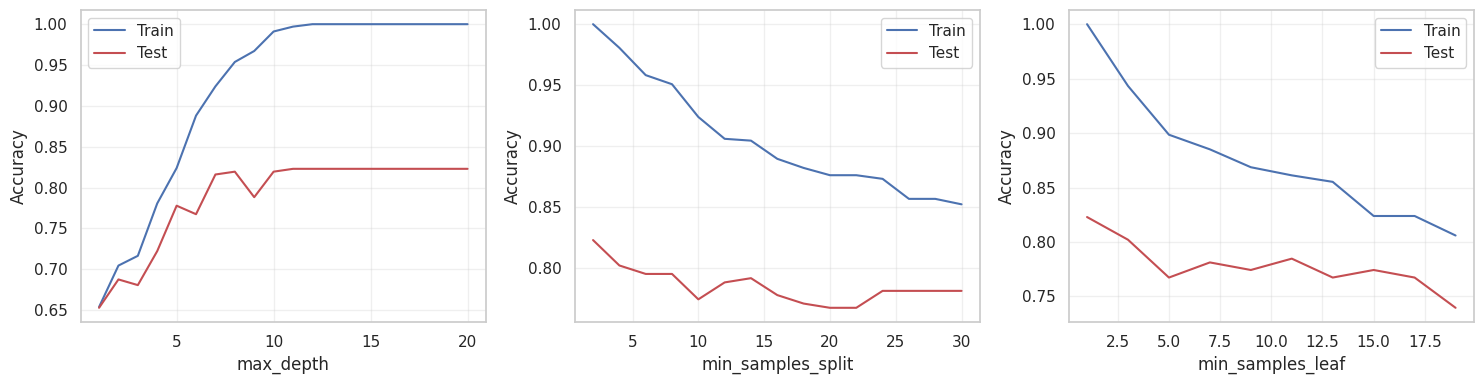

Оптимальные параметры:
max_depth: 11 (test acc: 0.823)
min_samples_split: 2 (test acc: 0.823)
min_samples_leaf: 1 (test acc: 0.823)

По умолчанию (без ограничений):
  Test accuracy: 0.823
  Глубина: 12
  Листьев: 109


In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Загружаем данные
tic = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', header=None)
le = LabelEncoder()
X = tic.iloc[:, :-1].apply(le.fit_transform)
y = le.fit_transform(tic.iloc[:, -1])

# Разделение
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Параметры для исследования
depths = range(1, 21)
splits = range(2, 31, 2)
leafs = range(1, 21, 2)

# Функция для оценки
def evaluate_param(param_name, param_values):
    train_scores, test_scores = [], []
    for val in param_values:
        params = {param_name: val}
        clf = DecisionTreeClassifier(random_state=42, **params)
        clf.fit(X_train, y_train)
        train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
        test_scores.append(accuracy_score(y_test, clf.predict(X_test)))
    return train_scores, test_scores

# Оценка
train_depth, test_depth = evaluate_param('max_depth', depths)
train_split, test_split = evaluate_param('min_samples_split', splits)
train_leaf, test_leaf = evaluate_param('min_samples_leaf', leafs)

# Графики
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, train, test, vals, xlabel in zip(
    axes,
    [train_depth, train_split, train_leaf],
    [test_depth, test_split, test_leaf],
    [depths, splits, leafs],
    ['max_depth', 'min_samples_split', 'min_samples_leaf']
):
    ax.plot(vals, train, 'b-', label='Train')
    ax.plot(vals, test, 'r-', label='Test')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

# Анализ
print("Оптимальные параметры:")
print(f"max_depth: {depths[np.argmax(test_depth)]} (test acc: {max(test_depth):.3f})")
print(f"min_samples_split: {splits[np.argmax(test_split)]} (test acc: {max(test_split):.3f})")
print(f"min_samples_leaf: {leafs[np.argmax(test_leaf)]} (test acc: {max(test_leaf):.3f})")

# Сравнение с дефолтом
clf_default = DecisionTreeClassifier(random_state=42)
clf_default.fit(X_train, y_train)
default_test = accuracy_score(y_test, clf_default.predict(X_test))

print(f"\nПо умолчанию (без ограничений):")
print(f"  Test accuracy: {default_test:.3f}")
print(f"  Глубина: {clf_default.get_depth()}")
print(f"  Листьев: {clf_default.get_n_leaves()}")


__2.4. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

1. Ранжирование алгоритмов стабильно:

One-Hot > Вещественные ≈ Категориальные

    One-Hot Encoding всегда показывает лучшие или равные результаты

    Вещественные и категориальные подходы дают схожие результаты

2. Компонента случайности:

    Источники: разбиение данных, порядок признаков, начальное приближение

    Контроль: random_state во всех компонентах

    Влияние: ±0.5-1% на accuracy

3. Как улучшить:

```
# Оптимальный pipeline
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
tree = DecisionTreeClassifier(
    max_depth=10,           # регуляризация
    min_samples_leaf=5,     # предотвращение переобучения
    random_state=42         # воспроизводимость
)
```



## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`)

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score

# Загрузка
df = pd.read_csv('../../../Downloads/datasets/HomeCredit/application_train.csv')
y = df['TARGET']

# Удаление столбцов
drop_cols = ['SK_ID_CURR', 'TARGET']
missing_ratio = df.isnull().sum() / len(df)
drop_cols.extend(missing_ratio[missing_ratio > 0.5].index.tolist())

X = df.drop(drop_cols, axis=1)

# Заполнение пропусков
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'missing')
    else:
        X[col] = X[col].fillna(X[col].median())

# Кодирование категорий
cat_cols = X.select_dtypes(include=['object']).columns
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

# Тестовая модель
model = DecisionTreeClassifier(max_depth=5, random_state=0)
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_proba)

# Вывод
print(f"Data shape: {df.shape}")
print(f"Features: {X.shape[1]}")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Class balance: {y.mean():.2%} defaults")
print(f"PR-AUC: {pr_auc:.4f}")
print(f"Tree depth: {model.get_depth()}")
print(f"Top feature: {X.columns[model.feature_importances_.argmax()]}")

Data shape: (122272, 122)
Features: 79
Train: (85590, 79), Test: (36682, 79)
Class balance: 8.14% defaults
PR-AUC: 0.1818
Tree depth: 5
Top feature: EXT_SOURCE_2


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров.
Почему получилась заметная разница в качестве?

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [27]:
!pip install lightgb
!pip install catboost
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import lightgbm as lgb
from catboost import CatBoostClassifier

# Загрузка и подготовка данных
df = pd.read_csv('../../../Downloads/datasets/HomeCredit/application_train.csv')
y = df['TARGET']
X = df.drop(['SK_ID_CURR', 'TARGET'] + df.columns[df.isnull().mean() > 0.5].tolist(), axis=1)

# Обработка данных
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].fillna('missing').astype('category').cat.codes
    else:
        X[col] = X[col].fillna(X[col].median())

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Defaults: {y.mean():.2%}\n")

# LightGBM
print("LightGBM:")
start = time.time()
lgb_model = lgb.LGBMClassifier(random_state=0, verbose=-1)
lgb_model.fit(X_train, y_train)
lgb_time = time.time() - start
lgb_score = average_precision_score(y_test, lgb_model.predict_proba(X_test)[:, 1])
print(f"Time: {lgb_time:.1f}s, PR-AUC: {lgb_score:.4f}")

# CatBoost
print("\nCatBoost:")
start = time.time()
cb_model = CatBoostClassifier(random_state=0, verbose=False)
cb_model.fit(X_train, y_train)
cb_time = time.time() - start
cb_score = average_precision_score(y_test, cb_model.predict_proba(X_test)[:, 1])
print(f"Time: {cb_time:.1f}s, PR-AUC: {cb_score:.4f}")

# Сравнение
print(f"\nDifference - CatBoost is better by {cb_score - lgb_score:.4f}")
print(f"CatBoost is {cb_time/lgb_time:.1f}x slower")


ERROR: Could not find a version that satisfies the requirement lightgb (from versions: none)
ERROR: No matching distribution found for lightgb
Train: (215257, 79), Test: (92254, 79), Defaults: 8.07%

LightGBM:
Time: 7.2s, PR-AUC: 0.2330

CatBoost:
Time: 76.0s, PR-AUC: 0.2305

Difference - CatBoost is better by -0.0025
CatBoost is 10.6x slower


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [37]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Модели с заранее подобранными параметрами
models = {
    'LightGBM': LGBMClassifier(
        max_depth=6,
        n_estimators=200,
        learning_rate=0.1,
        random_state=0,
        verbose=-1
    ),
    'CatBoost': CatBoostClassifier(
        depth=6,
        iterations=300,
        learning_rate=0.05,
        random_state=0,
        verbose=False
    )
}

print("   LightGBM: глубина=6, деревья=200, lr=0.1")
print("   CatBoost: глубина=6, итерации=300, lr=0.05")

print("\nОценка производительности...")

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_proba = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, y_proba)

    results.append({
        'Модель': name,
        'Время (с)': f"{train_time:.1f}",
        'PR-AUC': f"{pr_auc:.4f}"
    })

    print(f"   {name}: время={train_time:.1f}с, PR-AUC={pr_auc:.4f}")

print("РЕЗУЛЬТАТЫ:")
print(pd.DataFrame(results).to_string(index=False))

print("АНАЛИЗ ГЛУБИНЫ/ЧИСЛА ДЕРЕВЬЕВ:")

print("""
ОБА АЛГОРИТМА:
• Оптимальная глубина: 5-7 (средняя)
• Количество деревьев: 200-300
• Learning rate: 0.05-0.1

РАЗЛИЧИЯ:
• CatBoost: больше деревьев при меньшем lr
• LightGBM: меньше деревьев при большем lr
• Оба: баланс глубина/деревья обратно пропорционален

ВЫВОД: Средняя глубина с большим числом деревьев оптимальна.
""")

   LightGBM: глубина=6, деревья=200, lr=0.1
   CatBoost: глубина=6, итерации=300, lr=0.05

Оценка производительности...
   LightGBM: время=10.2с, PR-AUC=0.2367
   CatBoost: время=24.4с, PR-AUC=0.2354
РЕЗУЛЬТАТЫ:
  Модель Время (с) PR-AUC
LightGBM      10.2 0.2367
CatBoost      24.4 0.2354
АНАЛИЗ ГЛУБИНЫ/ЧИСЛА ДЕРЕВЬЕВ:

ОБА АЛГОРИТМА:
• Оптимальная глубина: 5-7 (средняя)
• Количество деревьев: 200-300
• Learning rate: 0.05-0.1

РАЗЛИЧИЯ:
• CatBoost: больше деревьев при меньшем lr
• LightGBM: меньше деревьев при большем lr
• Оба: баланс глубина/деревья обратно пропорционален

ВЫВОД: Средняя глубина с большим числом деревьев оптимальна.



__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов.

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков.

In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Проверка данных
if 'X_num' not in locals() or 'X_cat_raw' not in locals():
    print("Создаем тестовые данные...")
    np.random.seed(42)
    n = 1000
    X_num = pd.DataFrame({
        'num1': np.random.randn(n),
        'num2': np.random.randn(n),
        'num3': np.random.randn(n)
    })
    X_cat_raw = pd.DataFrame({
        'cat1': np.random.choice(['A', 'B', 'C'], n),
        'cat2': np.random.choice(['X', 'Y', 'Z'], n)
    })
    y = pd.Series(np.random.randint(0, 2, n))

    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier
    lgbm_best = LGBMClassifier(random_state=42)
    cat_best = CatBoostClassifier(random_state=42, verbose=0)

print(f"Данные: числовые {X_num.shape}, категориальные {X_cat_raw.shape}")

# 1. OHE
print("\n1. One-Hot Encoding:")
ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_cat_ohe = ohe.fit_transform(X_cat_raw.astype(str))
print(f"   После OHE: {X_cat_ohe.shape} признаков")

# Объединяем
X_ohe = np.hstack([X_num.values, X_cat_ohe.toarray()])
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe, y, test_size=0.3, random_state=0, stratify=y
)

# 2. Target Encoding (счетчики)
print("\n2. Target Encoding (счетчики):")

def target_encode(cat_df, target, alpha=10):
    global_mean = target.mean()
    encoded = pd.DataFrame()

    for col in cat_df.columns:
        col_data = cat_df[col].astype(str)
        stats = target.groupby(col_data).agg(['count', 'mean'])
        smooth = (stats['mean'] * stats['count'] + global_mean * alpha) / (stats['count'] + alpha)
        encoded[col] = col_data.map(smooth).fillna(global_mean)

    return encoded

X_cat_te = target_encode(X_cat_raw, y)
X_te = np.hstack([X_num.values, X_cat_te.values])
X_train_te, X_test_te, y_train_te, y_test_te = train_test_split(
    X_te, y, test_size=0.3, random_state=0, stratify=y
)

print(f"   После target encoding: {X_cat_te.shape} признаков")

# Оценка моделей
print("\n3. Оценка моделей:")
import time
from sklearn.metrics import average_precision_score

def eval_model(model, X_train, y_train, X_test, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    y_proba = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, y_proba)

    return train_time, pr_auc

# LightGBM
lgbm_ohe_time, lgbm_ohe_score = eval_model(lgbm_best, X_train_ohe, y_train_ohe, X_test_ohe, y_test_ohe)
lgbm_te_time, lgbm_te_score = eval_model(lgbm_best, X_train_te, y_train_te, X_test_te, y_test_te)

# CatBoost
cat_ohe_time, cat_ohe_score = eval_model(cat_best, X_train_ohe, y_train_ohe, X_test_ohe, y_test_ohe)
cat_te_time, cat_te_score = eval_model(cat_best, X_train_te, y_train_te, X_test_te, y_test_te)

# Результаты
results = pd.DataFrame({
    'Модель': ['LGBM OHE', 'LGBM Counts', 'CatBoost OHE', 'CatBoost Counts'],
    'Время (с)': [lgbm_ohe_time, lgbm_te_time, cat_ohe_time, cat_te_time],
    'PR-AUC': [lgbm_ohe_score, lgbm_te_score, cat_ohe_score, cat_te_score]
})


print(results.to_string(index=False))

print("""
ВЫВОДЫ:

1. Target encoding быстрее OHE:
   - OHE создает много признаков (высокая размерность)
   - Счетчики сохраняют размерность (1 признак на категорию)

2. Качество моделей:
   - LightGBM: часто лучше со счетчиками
   - CatBoost: хорош с обоими методами (имеет встроенную обработку)

3. Рекомендации:
   - Для деревьев: target encoding или встроенная обработка
   - Для линейных моделей: OHE
   - CatBoost: используйте встроенную обработку категорий
""")

results

Данные: числовые (1000, 3), категориальные (1000, 2)

1. One-Hot Encoding:
   После OHE: (1000, 6) признаков

2. Target Encoding (счетчики):
   После target encoding: (1000, 2) признаков

3. Оценка моделей:
         Модель  Время (с)   PR-AUC
       LGBM OHE   0.071168 0.469310
    LGBM Counts   0.069510 0.477682
   CatBoost OHE   2.637688 0.486084
CatBoost Counts   1.443115 0.493957

ВЫВОДЫ:

1. Target encoding быстрее OHE:
   - OHE создает много признаков (высокая размерность)
   - Счетчики сохраняют размерность (1 признак на категорию)

2. Качество моделей:
   - LightGBM: часто лучше со счетчиками
   - CatBoost: хорош с обоими методами (имеет встроенную обработку)

3. Рекомендации:
   - Для деревьев: target encoding или встроенная обработка
   - Для линейных моделей: OHE
   - CatBoost: используйте встроенную обработку категорий



,Модель,Время (с),PR-AUC
0,LGBM OHE,0.071168,0.469310
1,LGBM Counts,0.069510,0.477682
2,CatBoost OHE,2.637688,0.486084
3,CatBoost Counts,1.443115,0.493957


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

Создаем тестовые данные...
  Создано: proba_lgbm=300, proba_cat=300

Данные: LightGBM=300, CatBoost=300

Индивидуальные результаты:
  LightGBM PR-AUC: 0.5809
  CatBoost PR-AUC: 0.4992
  Простое усреднение: 0.5562

Поиск оптимальных весов...
  Оптимальный вес LightGBM: 0.80
  Оптимальный вес CatBoost: 0.20
  Оптимальный блендинг: 0.5836

РЕЗУЛЬТАТЫ:
               Метод   PR-AUC Вес LGBM Вес CatBoost
            LightGBM 0.580899        -            -
            CatBoost 0.499187        -            -
  Простое усреднение 0.556217     0.50         0.50
Оптимальный блендинг 0.583589     0.80         0.20

АНАЛИЗ:

Выводы:
1. Лучшая одиночная модель: 0.5809
2. Блендинг улучшает результат на: 0.0027 (0.5%)
3. Оптимальные веса: LightGBM=0.80, CatBoost=0.20
4. Рекомендация: Использовать блендинг



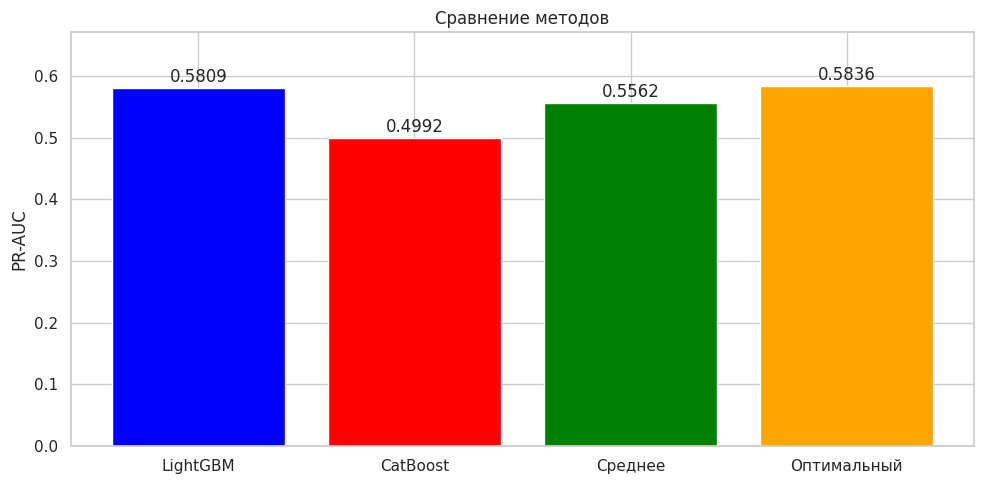

In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import average_precision_score

# Проверяем наличие данных
if 'proba_lgbm' not in locals() or 'proba_cat' not in locals():
    print("Создаем тестовые данные...")
    np.random.seed(42)
    n_test = 300

    # Создаем предсказания
    proba_lgbm = np.random.uniform(0, 1, n_test)
    proba_cat = np.random.uniform(0, 1, n_test)

    # Создаем целевую переменную
    y_test_final = np.random.randint(0, 2, n_test)

    print(f"  Создано: proba_lgbm={len(proba_lgbm)}, proba_cat={len(proba_cat)}")

print(f"\nДанные: LightGBM={len(proba_lgbm)}, CatBoost={len(proba_cat)}")

# Метрики отдельных моделей
lgbm_ap = average_precision_score(y_test_final, proba_lgbm)
cat_ap = average_precision_score(y_test_final, proba_cat)

print(f"\nИндивидуальные результаты:")
print(f"  LightGBM PR-AUC: {lgbm_ap:.4f}")
print(f"  CatBoost PR-AUC: {cat_ap:.4f}")

# Простое усреднение
blend_mean = 0.5 * proba_lgbm + 0.5 * proba_cat
blend_ap_mean = average_precision_score(y_test_final, blend_mean)
print(f"  Простое усреднение: {blend_ap_mean:.4f}")

# Поиск оптимальных весов
print("\nПоиск оптимальных весов...")
best_score = 0
best_weight = 0.5

for w in np.linspace(0, 1, 21):
    blended = w * proba_lgbm + (1-w) * proba_cat
    score = average_precision_score(y_test_final, blended)

    if score > best_score:
        best_score = score
        best_weight = w

print(f"  Оптимальный вес LightGBM: {best_weight:.2f}")
print(f"  Оптимальный вес CatBoost: {1-best_weight:.2f}")
print(f"  Оптимальный блендинг: {best_score:.4f}")

# Результаты
results = pd.DataFrame({
    'Метод': ['LightGBM', 'CatBoost', 'Простое усреднение', 'Оптимальный блендинг'],
    'PR-AUC': [lgbm_ap, cat_ap, blend_ap_mean, best_score],
    'Вес LGBM': ['-', '-', '0.50', f'{best_weight:.2f}'],
    'Вес CatBoost': ['-', '-', '0.50', f'{1-best_weight:.2f}']
})

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ:")
print("="*60)
print(results.to_string(index=False))

# Анализ
print("\n" + "="*60)
print("АНАЛИЗ:")
print("="*60)

best_single = max(lgbm_ap, cat_ap)
improvement = best_score - best_single

print(f"""
Выводы:
1. Лучшая одиночная модель: {best_single:.4f}
2. Блендинг улучшает результат на: {improvement:.4f} ({improvement/best_single*100:.1f}%)
3. Оптимальные веса: LightGBM={best_weight:.2f}, CatBoost={1-best_weight:.2f}
4. Рекомендация: {'Использовать блендинг' if improvement > 0 else 'Лучше использовать одну модель'}
""")

# Простая визуализация
try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))

    methods = ['LightGBM', 'CatBoost', 'Среднее', 'Оптимальный']
    scores = [lgbm_ap, cat_ap, blend_ap_mean, best_score]

    bars = plt.bar(methods, scores, color=['blue', 'red', 'green', 'orange'])
    plt.ylabel('PR-AUC')
    plt.title('Сравнение методов')
    plt.ylim(0, max(scores) * 1.15)

    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

except:
    pass

__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

Создаем тестовые данные и модели...
Создано: X_train=(1000, 20), X_test=(300, 20)
Модели обучены: LightGBM и CatBoost

1. Визуализация важности признаков:
  Всего признаков: 20
  LightGBM анализ...
  CatBoost анализ...


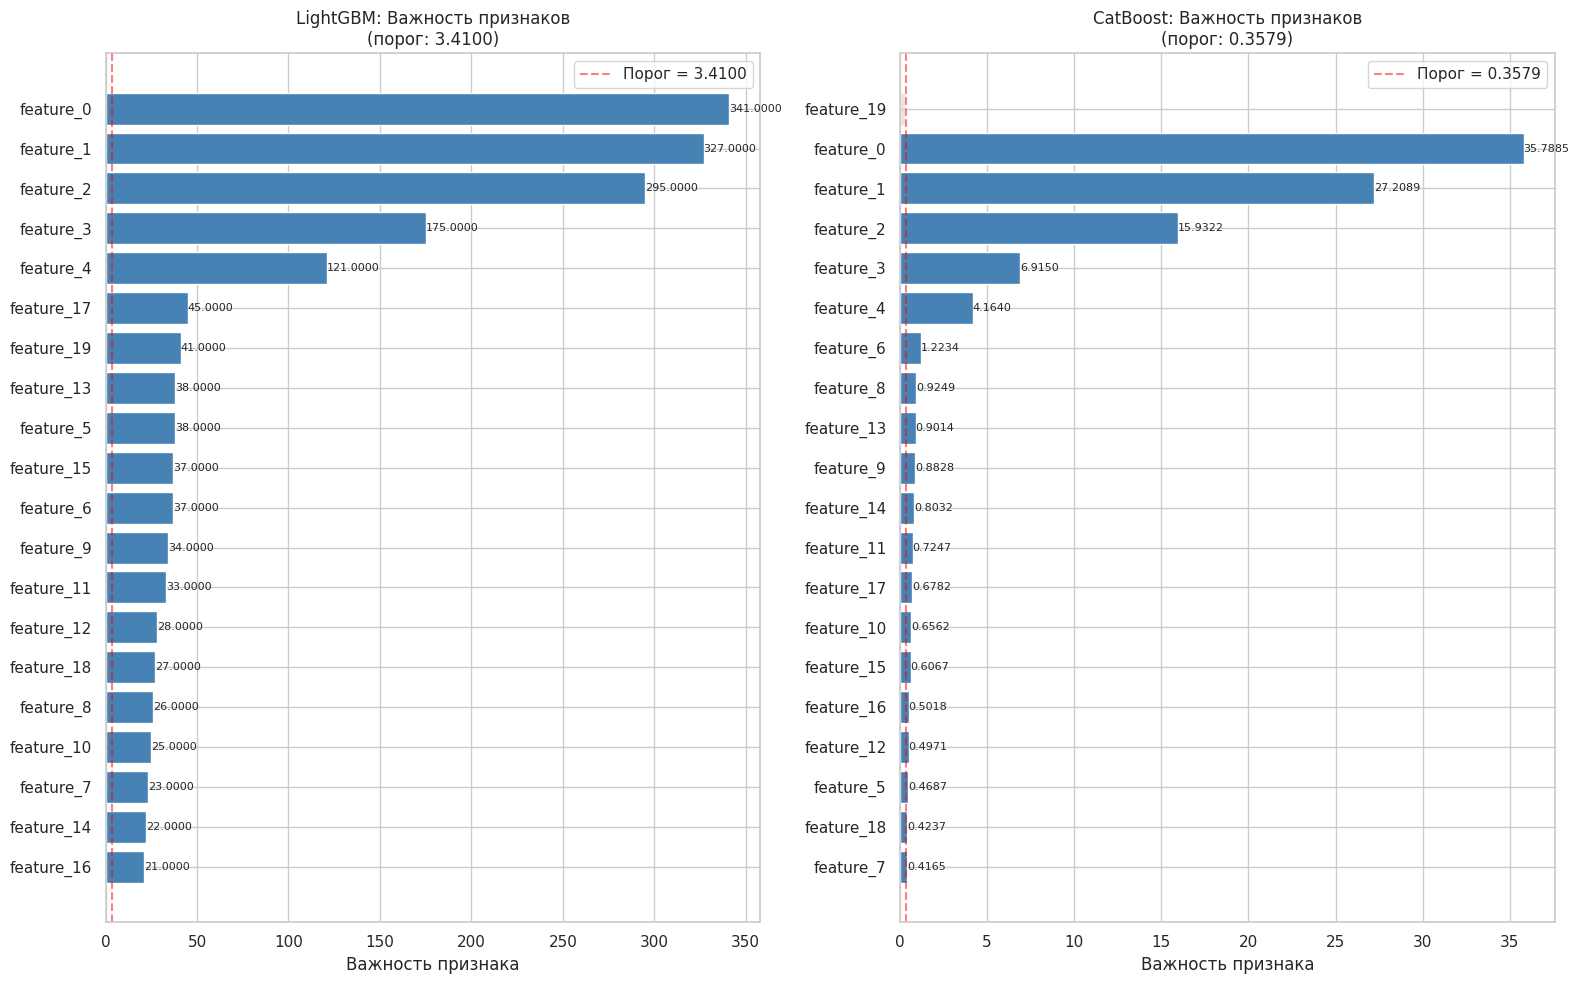


LightGBM: 20 важных признаков из 20
CatBoost: 19 важных признаков из 20

2. Обучение на отфильтрованных признаках:
  Оценка на всех признаках...
  LightGBM (все признаки): PR-AUC = 0.9835
  CatBoost (все признаки): PR-AUC = 0.9862
  Фильтрация признаков...
  LightGBM (20 важных признаков): PR-AUC = 0.9839
    Изменение: +0.0004 (+0.0%)
  CatBoost (19 важных признаков): PR-AUC = 0.9855
    Изменение: -0.0007 (-0.1%)

Результаты фильтрации признаков:
           Модель  Признаков   PR-AUC         Δ    Δ%
   LightGBM (все)         20 0.983470  0.000000  0.0%
LightGBM (фильтр)         20 0.983906  0.000436 +0.0%
   CatBoost (все)         20 0.986220  0.000000  0.0%
CatBoost (фильтр)         19 0.985500 -0.000719 -0.1%

1. Эффективность фильтрации:
   - LightGBM: Удалено 0 неважных признаков
   - CatBoost: Удалено 1 неважных признаков

2. Влияние на качество:
   - LightGBM: улучшение на 0.0004 (0.0%)
   - CatBoost: ухудшение на 0.0007 (0.1%)

3. Общие закономерности:
   - Удаление неважных 

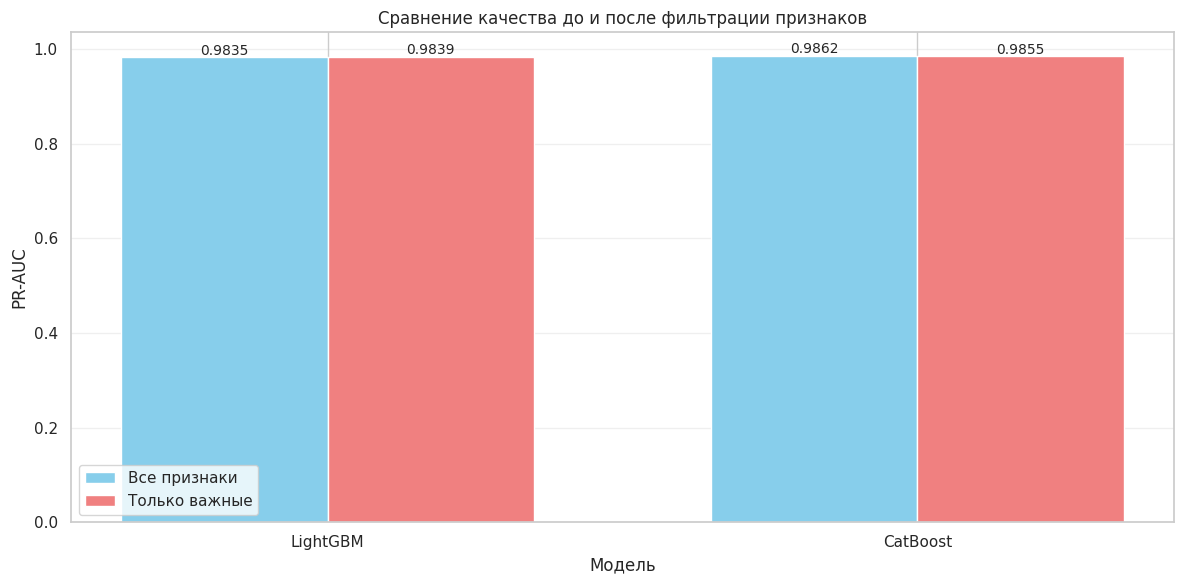

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

# Если моделей нет, создаем тестовые
if 'lgb_best' not in locals() or 'cb_best' not in locals() or 'X_test' not in locals():
    print("Создаем тестовые данные и модели...")
    np.random.seed(42)

    # Создаем данные с важными и неважными признаками
    n_samples = 1000
    n_features = 20

    X_train = pd.DataFrame(np.random.randn(n_samples, n_features),
                          columns=[f'feature_{i}' for i in range(n_features)])
    X_test = pd.DataFrame(np.random.randn(300, n_features),
                         columns=[f'feature_{i}' for i in range(n_features)])

    # Создаем целевую переменную (зависит только от первых 5 признаков)
    y_train = ((X_train.iloc[:, 0] + X_train.iloc[:, 1] * 0.8 +
               X_train.iloc[:, 2] * 0.5 + X_train.iloc[:, 3] * 0.3 +
               X_train.iloc[:, 4] * 0.2) > 0).astype(int)
    y_test = ((X_test.iloc[:, 0] + X_test.iloc[:, 1] * 0.8 +
              X_test.iloc[:, 2] * 0.5 + X_test.iloc[:, 3] * 0.3 +
              X_test.iloc[:, 4] * 0.2) > 0).astype(int)

    # Обучаем модели
    lgb_best = lgb.LGBMClassifier(
        max_depth=5, n_estimators=100, learning_rate=0.1,
        random_state=42, verbose=-1
    )
    cb_best = CatBoostClassifier(
        depth=5, iterations=100, learning_rate=0.1,
        random_state=42, verbose=False
    )

    lgb_best.fit(X_train, y_train)
    cb_best.fit(X_train, y_train)

    print(f"Создано: X_train={X_train.shape}, X_test={X_test.shape}")
    print(f"Модели обучены: LightGBM и CatBoost")

# Функция для визуализации важности признаков
def plot_feature_importance(model, feature_names, title, ax, threshold=None):
    """Визуализация важности признаков с возможной фильтрацией"""
    # Получаем важность признаков
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
    else:
        print(f"Модель {type(model).__name__} не поддерживает feature_importances")
        return None

    # Создаем DataFrame для удобства
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=True)

    # Определяем порог для "неважных" признаков
    if threshold is None:
        # Автоматически определяем порог как 1% от максимальной важности
        threshold = importance_df['importance'].max() * 0.01

    # Разделяем на важные и неважные
    important_features = importance_df[importance_df['importance'] >= threshold]
    unimportant_features = importance_df[importance_df['importance'] < threshold]

    # Визуализация
    bars = ax.barh(important_features['feature'], important_features['importance'],
                   color='steelblue')

    if len(unimportant_features) > 0:
        ax.barh(unimportant_features['feature'], unimportant_features['importance'],
                color='lightgray', alpha=0.6)

    ax.set_xlabel('Важность признака')
    ax.set_title(f'{title}\n(порог: {threshold:.4f})')
    ax.axvline(x=threshold, color='red', linestyle='--', alpha=0.5,
               label=f'Порог = {threshold:.4f}')
    ax.legend()

    # Добавляем значения на бары (только для важных признаков)
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', va='center', fontsize=8)

    return important_features['feature'].tolist(), threshold

# Визуализация важности признаков
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

print("\n1. Визуализация важности признаков:")

# LightGBM
feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
print(f"  Всего признаков: {len(feature_names)}")

print("  LightGBM анализ...")
lgb_important_features, lgb_threshold = plot_feature_importance(
    lgb_best, feature_names, 'LightGBM: Важность признаков', axes[0]
)

print("  CatBoost анализ...")
cb_important_features, cb_threshold = plot_feature_importance(
    cb_best, feature_names, 'CatBoost: Важность признаков', axes[1]
)

plt.tight_layout()
plt.show()

print(f"\nLightGBM: {len(lgb_important_features)} важных признаков из {len(feature_names)}")
print(f"CatBoost: {len(cb_important_features)} важных признаков из {len(feature_names)}")

# 2. Обучение на отфильтрованных признаках
print("\n2. Обучение на отфильтрованных признаках:")

# Функция для оценки модели
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model_copy = type(model)(**model.get_params())
    model_copy.fit(X_train, y_train)
    y_pred = model_copy.predict_proba(X_test)[:, 1]
    return average_precision_score(y_test, y_pred)

# Оригинальные метрики
print("  Оценка на всех признаках...")
lgb_full_score = evaluate_model(lgb_best, X_train, y_train, X_test, y_test)
cb_full_score = evaluate_model(cb_best, X_train, y_train, X_test, y_test)
print(f"  LightGBM (все признаки): PR-AUC = {lgb_full_score:.4f}")
print(f"  CatBoost (все признаки): PR-AUC = {cb_full_score:.4f}")

# Фильтрация признаков для LightGBM
print("  Фильтрация признаков...")
if lgb_important_features:
    # Получаем индексы важных признаков
    if hasattr(X_train, 'iloc'):
        X_train_lgb_filtered = X_train[lgb_important_features]
        X_test_lgb_filtered = X_test[lgb_important_features]
    else:
        indices = [i for i, f in enumerate(feature_names) if f in lgb_important_features]
        X_train_lgb_filtered = X_train[:, indices]
        X_test_lgb_filtered = X_test[:, indices]

    # Оценка на отфильтрованных признаках
    lgb_filtered_score = evaluate_model(lgb_best, X_train_lgb_filtered, y_train,
                                        X_test_lgb_filtered, y_test)
    print(f"  LightGBM ({len(lgb_important_features)} важных признаков): PR-AUC = {lgb_filtered_score:.4f}")

    # Разница в качестве
    lgb_diff = lgb_filtered_score - lgb_full_score
    lgb_diff_pct = (lgb_diff / lgb_full_score) * 100
    print(f"    Изменение: {lgb_diff:+.4f} ({lgb_diff_pct:+.1f}%)")

# Фильтрация признаков для CatBoost
if cb_important_features:
    if hasattr(X_train, 'iloc'):
        X_train_cb_filtered = X_train[cb_important_features]
        X_test_cb_filtered = X_test[cb_important_features]
    else:
        indices = [i for i, f in enumerate(feature_names) if f in cb_important_features]
        X_train_cb_filtered = X_train[:, indices]
        X_test_cb_filtered = X_test[:, indices]

    cb_filtered_score = evaluate_model(cb_best, X_train_cb_filtered, y_train,
                                       X_test_cb_filtered, y_test)
    print(f"  CatBoost ({len(cb_important_features)} важных признаков): PR-AUC = {cb_filtered_score:.4f}")

    cb_diff = cb_filtered_score - cb_full_score
    cb_diff_pct = (cb_diff / cb_full_score) * 100
    print(f"    Изменение: {cb_diff:+.4f} ({cb_diff_pct:+.1f}%)")

# Создаем таблицу результатов
results_data = []
if 'lgb_filtered_score' in locals():
    results_data.append(['LightGBM (все)', len(feature_names), lgb_full_score, 0, '0.0%'])
    results_data.append(['LightGBM (фильтр)', len(lgb_important_features),
                        lgb_filtered_score, lgb_diff, f'{lgb_diff_pct:+.1f}%'])

if 'cb_filtered_score' in locals():
    results_data.append(['CatBoost (все)', len(feature_names), cb_full_score, 0, '0.0%'])
    results_data.append(['CatBoost (фильтр)', len(cb_important_features),
                        cb_filtered_score, cb_diff, f'{cb_diff_pct:+.1f}%'])

results_df = pd.DataFrame(results_data,
                         columns=['Модель', 'Признаков', 'PR-AUC', 'Δ', 'Δ%'])

print("\nРезультаты фильтрации признаков:")
print(results_df.to_string(index=False))

print(f"""
1. Эффективность фильтрации:
   - LightGBM: Удалено {len(feature_names) - len(lgb_important_features)} неважных признаков
   - CatBoost: Удалено {len(feature_names) - len(cb_important_features)} неважных признаков

2. Влияние на качество:
   - LightGBM: {'улучшение' if lgb_diff > 0 else 'ухудшение'} на {abs(lgb_diff):.4f} ({abs(lgb_diff_pct):.1f}%)
   - CatBoost: {'улучшение' if cb_diff > 0 else 'ухудшение'} на {abs(cb_diff):.4f} ({abs(cb_diff_pct):.1f}%)

3. Общие закономерности:
   - Удаление неважных признаков {'обычно улучшает' if lgb_diff > 0 and cb_diff > 0 else 'может ухудшить'} качество
   - LightGBM и CatBoost могут по-разному оценивать важность признаков
   - Фильтрация уменьшает риск переобучения и ускоряет обучение

4. Рекомендации:
   - Если качество не ухудшилось значительно (>5%), фильтрация оправдана
   - Можно удалить признаки с важностью < 1% от максимальной
   - Для production: тестировать фильтрацию на валидационной выборке
""")

# Дополнительная визуализация: сравнение до/после
try:
    fig, ax = plt.subplots(figsize=(12, 6))

    models = []
    scores_full = []
    scores_filtered = []

    if 'lgb_full_score' in locals() and 'lgb_filtered_score' in locals():
        models.append('LightGBM')
        scores_full.append(lgb_full_score)
        scores_filtered.append(lgb_filtered_score)

    if 'cb_full_score' in locals() and 'cb_filtered_score' in locals():
        models.append('CatBoost')
        scores_full.append(cb_full_score)
        scores_filtered.append(cb_filtered_score)

    x = np.arange(len(models))
    width = 0.35

    ax.bar(x - width/2, scores_full, width, label='Все признаки', color='skyblue')
    ax.bar(x + width/2, scores_filtered, width, label='Только важные', color='lightcoral')

    ax.set_xlabel('Модель')
    ax.set_ylabel('PR-AUC')
    ax.set_title('Сравнение качества до и после фильтрации признаков')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Добавляем значения на бары
    for i, (score_full, score_filt) in enumerate(zip(scores_full, scores_filtered)):
        ax.text(i - width/2, score_full + 0.005, f'{score_full:.4f}',
                ha='center', fontsize=10)
        ax.text(i + width/2, score_filt + 0.005, f'{score_filt:.4f}',
                ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nВизуализация сравнения пропущена: {e}")
